# Model Analysis
This notebook trains a machine learning model to predict LaLiga match outcomes. The model classifies each match as:
- **1**: Home team wins
- **2**: Away team wins
- **0**: Draw


In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the two tables from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)
df_predictions = pd.read_sql_query("SELECT * from Predictions", con)

# close the connection of the database
con.close()

### clean dataset

In [3]:
# creating two new columns, one for the score of the home team, and one for the score of the away team
df_matches[['home_score', 'away_score']] = df_matches['score'].str.split(':', expand=True).astype(float)

# creating one new column to show which team won (1 for home team, 2 for away team), or if it was a tie (X)
df_matches['winner'] = df_matches.apply(lambda row: 
                                        np.nan if pd.isna(row['home_score']) or pd.isna(row['away_score'])
                                        else 1 if row['home_score'] > row['away_score']
                                        else 2 if row['home_score'] < row['away_score']
                                        else 'X', axis=1)

df_matches = df_matches.drop(columns=['time', 'date'])
df_matches.dropna(inplace=True)
df_matches = df_matches[df_matches['season'].isin(['2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'])]

In [4]:
df = df_matches.copy()[['season','division','matchday','home_team','away_team','home_score','away_score','winner']].dropna()
df['home_score'] = df['home_score'].astype(int)
df['away_score'] = df['away_score'].astype(int)
df

def get_last_results(row):
    season = row['season']
    division = row['division']
    matchday = row['matchday']
    team = row['team']
    
    filtered = final_result[
        (final_result['season'] == season) &
        (final_result['division'] == division) &
        (final_result['matchday'] <= matchday) &
        (final_result['matchday'] >= max(1, matchday - 4)) &
        (final_result['team'] == team)
    ]
    return filtered['result'].tolist()[-5:]


df_filtered = df.dropna(subset=['home_score', 'away_score', 'winner'])


home_grouped = df_filtered.groupby(['season', 'division', 'matchday', 'home_team']).agg(
    GF=('home_score', 'sum'),
    GA=('away_score', 'sum'),
    W=('winner', lambda x: (x == 1).sum()),
    L=('winner', lambda x: (x == 2).sum()),
    T=('winner', lambda x: (x == 'X').sum())
).reset_index()


away_grouped = df_filtered.groupby(['season', 'division', 'matchday', 'away_team']).agg(
    GF=('away_score', 'sum'),
    GA=('home_score', 'sum'),
    W=('winner', lambda x: (x == 2).sum()),
    L=('winner', lambda x: (x == 1).sum()),
    T=('winner', lambda x: (x == 'X').sum())
).reset_index()


away_grouped.rename(columns={'away_team': 'team'}, inplace=True)


combined = pd.concat([home_grouped.rename(columns={'home_team': 'team', 'result': 'home_result'}),
                      away_grouped.rename(columns={'away_team': 'team', 'result': 'away_result'})]).fillna(0)


combined['result'] = combined.apply(
    lambda row: 'W' if row['W'] > 0 else ('L' if row['L'] > 0 else 'T'), axis=1
)


combined['GD'] = combined['GF'] - combined['GA']
combined['Pts'] = combined['W'] * 3 + combined['T']


final_result = combined.groupby(['season', 'division', 'matchday', 'team']).agg(
    GF=('GF', 'sum'),
    GA=('GA', 'sum'),
    GD=('GD', 'sum'),
    W=('W', 'sum'),
    L=('L', 'sum'),
    T=('T', 'sum'),
    Pts=('Pts', 'sum'),
    result = ('result', 'first')
).reset_index()


final_result = final_result.sort_values(by=['season', 'division', 'matchday', 'team'])
final_result[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']] = final_result.groupby(['season', 'division', 'team'])[
    ['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']
].cumsum()


final_result = final_result.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[True, True, True, False, False, False])
final_result['rank'] = final_result.groupby(['season', 'division', 'matchday']).cumcount() + 1
final_result = final_result.sort_values(by=['season', 'division', 'matchday', 'rank'], ascending=[False, True, True, True]).reset_index(drop=True)


final_result = final_result[['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'result']]

final_result['last_5'] = final_result.apply(get_last_results, axis=1)
final_result_home = final_result.rename(columns={'team':'home_team'})
final_result_away = final_result.rename(columns={'team':'away_team'})

In [5]:
# Determine the last matchday per season and division in final_result
last_matchday_per_season = final_result.groupby(['season', 'division'])['matchday'].max().reset_index()
last_matchday_per_season = last_matchday_per_season.rename(columns={'matchday': 'last_matchday'})

# Merge this information into df_matches to determine which matchday data to pull
df_matches = df_matches.merge(last_matchday_per_season, on=['season', 'division'], how='left')

# Create columns for the correct `matchday` to look up in `final_result`:
# If matchday is 1, use the last matchday from the previous season; otherwise, use `matchday - 1`
df_matches['lookup_matchday'] = df_matches.apply(
    lambda row: row['last_matchday'] if row['matchday'] == 1 else row['matchday'] - 1,
    axis=1
)

# For merging purposes, add one more step to handle cases for the previous season if matchday is 1
df_matches['lookup_season'] = df_matches.apply(
    lambda row: str(int(row['season'].split('-')[0]) - 1) + '-' + str(int(row['season'].split('-')[1]) - 1) 
    if row['matchday'] == 1 else row['season'],
    axis=1
)

In [6]:
merged_df = df_matches.merge(final_result_home, left_on=['lookup_season', 'division', 'lookup_matchday', 'home_team'],
                                                right_on=['season', 'division', 'matchday', 'home_team'], how='left')
merged_df = merged_df.merge(final_result_away, left_on=['lookup_season', 'division', 'lookup_matchday', 'away_team'],
                                               right_on=['season', 'division', 'matchday', 'away_team'], how='left', suffixes=('_home', '_away'))
df_matches_final = merged_df.drop(columns=['lookup_matchday', 'lookup_season', 'last_matchday', 'season_y', 'matchday_y', 'season', 'matchday'])

In [9]:
df_matches_final['winner'] = df_matches_final.apply(lambda row: 
                                                    np.nan if pd.isna(row['winner'])
                                                    else 1 if row['winner'] == 1
                                                    else 3 if row['winner'] == 2
                                                    else 2, axis=1)
columns_to_fill = [
    'GF_home', 'GA_home', 'GD_home', 'W_home', 'L_home', 'T_home', 'Pts_home', 'rank_home', 'result_home', 'last_5_home',
    'GF_away', 'GA_away', 'GD_away', 'W_away', 'L_away', 'T_away', 'Pts_away', 'rank_away', 'result_away', 'last_5_away'
]
df_matches_final[columns_to_fill] = df_matches_final[columns_to_fill].fillna(0)

df_matches_final['home_team'] = df_matches_final['home_team'].astype('category').cat.codes
df_matches_final['away_team'] = df_matches_final['away_team'].astype('category').cat.codes

df_matches_final['GDD'] = df_matches_final['GD_home'] - df_matches_final['GD_away']

def count_points(last_5):
    if last_5 == 0:
        return 0
        
    count = 0
    for i in last_5:
        if i == 'W':
            count += 3
        elif i == 'T':
            count += 1
    return count

df_matches_final['last_5_home'] = df_matches_final['last_5_home'].apply(lambda x: count_points(x))
df_matches_final['last_5_away'] = df_matches_final['last_5_away'].apply(lambda x: count_points(x))

df_matches_final[df_matches_final['matchday_x'] == 1]

,season_x,division,matchday_x,home_team,away_team,score,home_score,away_score,winner,rank_home,...,GF_away,GA_away,GD_away,W_away,L_away,T_away,Pts_away,result_away,last_5_away,GDD
0,2010-2011,1,1,31,3,0:1,0.0,1.0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,2010-2011,1,1,35,61,1:3,1.0,3.0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
2,2010-2011,1,1,32,55,1:4,1.0,4.0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
3,2010-2011,1,1,24,27,3:1,3.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
4,2010-2011,1,1,47,62,1:0,1.0,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7964,2019-2020,2,1,22,46,3:2,3.0,2.0,1,6.0,...,48.0,48.0,0.0,17.0,13.0,12.0,63.0,L,6,18.0
7965,2019-2020,2,1,14,2,0:1,0.0,1.0,3,17.0,...,36.0,42.0,-6.0,14.0,18.0,10.0,52.0,L,1,0.0
7966,2019-2020,2,1,29,56,1:1,1.0,1.0,2,0.0,...,43.0,38.0,5.0,16.0,13.0,13.0,61.0,W,7,-5.0
7967,2019-2020,2,1,20,36,3:1,3.0,1.0,1,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,17.0


In [10]:
df_matches_final.corr(numeric_only=True).style.background_gradient("coolwarm", vmin=-1, vmax=1)

,division,matchday_x,home_team,away_team,home_score,away_score,winner,rank_home,GF_home,GA_home,GD_home,W_home,L_home,T_home,Pts_home,last_5_home,rank_away,GF_away,GA_away,GD_away,W_away,L_away,T_away,Pts_away,last_5_away,GDD
division,1.000000,0.085382,-0.076506,-0.076506,-0.075391,-0.062183,-0.009806,0.087277,-0.026622,-0.024865,-0.004415,0.007741,0.012736,0.209290,0.052009,-0.020582,0.071840,-0.026700,-0.026115,-0.003092,0.007001,0.010617,0.204980,0.050338,-0.017707,-0.000964
matchday_x,0.085382,1.000000,-0.002780,-0.010285,0.003773,0.001989,-0.008885,0.018839,0.736218,0.796582,-0.006475,0.697762,0.728382,0.736251,0.771262,0.179347,0.052055,0.748075,0.809964,-0.006494,0.706270,0.738400,0.750204,0.781057,0.190188,-0.000045
home_team,-0.076506,-0.002780,1.000000,-0.027743,0.008309,0.037295,0.014185,-0.010593,-0.006080,0.034504,-0.048433,-0.029487,0.015152,0.000708,-0.025718,-0.031654,-0.011981,0.004536,0.006482,-0.001907,-0.003354,0.006305,-0.019099,-0.007059,-0.012205,-0.032933
away_team,-0.076506,-0.010285,-0.027743,1.000000,0.023247,-0.005664,-0.017702,-0.002829,0.002414,0.000586,0.002370,0.001278,-0.006197,-0.028962,-0.005136,-0.016145,-0.008457,-0.007761,0.027701,-0.042883,-0.030402,0.009000,-0.000826,-0.026836,-0.025490,0.031632
home_score,-0.075391,0.003773,0.008309,0.023247,1.000000,-0.004236,-0.604238,-0.170471,0.142342,-0.039285,0.226877,0.127071,-0.090183,-0.055370,0.099525,0.141084,0.102706,-0.047988,0.064266,-0.137849,-0.070571,0.080148,-0.013987,-0.064896,-0.071094,0.256806
away_score,-0.062183,0.001989,0.037295,-0.005664,-0.004236,1.000000,0.608548,0.071228,-0.026335,0.057923,-0.101758,-0.051219,0.066274,-0.012004,-0.047531,-0.071431,-0.144791,0.117672,-0.038848,0.196763,0.117710,-0.078819,-0.041861,0.094188,0.103838,-0.209437
winner,-0.009806,-0.008885,0.014185,-0.017702,-0.604238,0.608548,1.000000,0.131424,-0.089530,0.049991,-0.172538,-0.097841,0.083742,0.012555,-0.083130,-0.111555,-0.159991,0.094515,-0.069020,0.203031,0.111066,-0.103604,-0.024582,0.092088,0.106679,-0.263892
rank_home,0.087277,0.018839,-0.010593,-0.002829,-0.170471,0.071228,0.131424,1.000000,-0.324225,0.265342,-0.724325,-0.481724,0.438376,0.105456,-0.399865,-0.573672,0.011878,-0.015713,-0.011496,-0.006428,-0.012830,-0.006318,-0.007880,-0.012949,-0.009554,-0.507968
GF_home,-0.026622,0.736218,-0.006080,0.002414,0.142342,-0.026335,-0.089530,-0.324225,1.000000,0.668513,0.479192,0.935248,0.464556,0.571575,0.944046,0.410778,0.012669,0.659792,0.716340,-0.008062,0.621673,0.652287,0.618616,0.678505,0.129000,0.344658
GA_home,-0.024865,0.796582,0.034504,0.000586,-0.039285,0.057923,0.049991,0.265342,0.668513,1.000000,-0.332407,0.536464,0.924420,0.677790,0.617114,-0.003382,0.005921,0.717328,0.770423,0.001208,0.672133,0.697147,0.654595,0.730509,0.134293,-0.236021


In [10]:
df_matches_final.count()

season_x       8420
division       8420
matchday_x     8420
home_team      8420
away_team      8420
score          8420
home_score     8420
away_score     8420
winner         8420
rank_home      8420
GF_home        8420
GA_home        8420
GD_home        8420
W_home         8420
L_home         8420
T_home         8420
Pts_home       8420
result_home    8420
last_5_home    8420
rank_away      8420
GF_away        8420
GA_away        8420
GD_away        8420
W_away         8420
L_away         8420
T_away         8420
Pts_away       8420
result_away    8420
last_5_away    8420
GDD            8420
dtype: int64

In [77]:
target = 'winner'
# features = ['rank_home', 'rank_away', 'W_home', 'W_away', 'L_home', 'L_away', 'T_home', 'T_away', 'home_team', 'away_team', 'GD_home', 'GD_away']
features = ['last_5_home', 'last_5_away', 'GD_home', 'GD_away', 'L_home', 'L_away']#, 'home_score', 'away_score']
X, y = df_matches_final[features], df_matches_final[target]

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6736, 6)
X_test shape: (1684, 6)
y_train shape: (6736,)
y_test shape: (1684,)


In [79]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1684 points : 875


Accuracy: 0.48
Classification Report:
               precision    recall  f1-score   support

           1       0.51      0.80      0.62       807
           2       0.35      0.15      0.21       431
           3       0.41      0.22      0.29       446

    accuracy                           0.48      1684
   macro avg       0.43      0.39      0.38      1684
weighted avg       0.44      0.48      0.43      1684



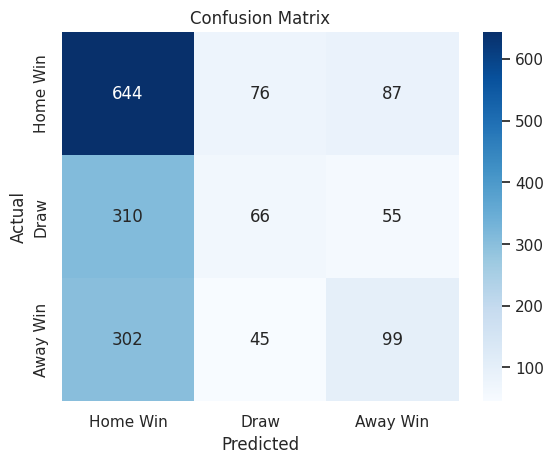

In [80]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [97]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [98]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred.astype(int)
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,home_team,away_team,rank_home,rank_away,W_home,W_away,L_home,L_away,T_home,T_away,y_real,y_pred,err,%_err
368,20,28,15.0,20.0,10.0,5.0,13.0,26.0,13.0,5.0,1,1,0,0.000000
1002,5,41,2.0,16.0,16.0,6.0,4.0,12.0,4.0,6.0,1,1,0,0.000000
807,48,8,13.0,20.0,1.0,0.0,2.0,4.0,1.0,0.0,3,1,2,66.666667
685,22,3,4.0,8.0,12.0,10.0,7.0,7.0,11.0,13.0,1,1,0,0.000000
81,34,0,9.0,19.0,4.0,1.0,3.0,7.0,1.0,0.0,1,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133,33,46,6.0,1.0,2.0,5.0,1.0,0.0,3.0,1.0,3,1,2,66.666667
1084,48,3,8.0,9.0,12.0,11.0,10.0,9.0,10.0,12.0,2,1,1,50.000000
1477,23,17,17.0,20.0,10.0,8.0,14.0,18.0,6.0,4.0,2,1,1,50.000000
508,49,34,16.0,12.0,2.0,4.0,5.0,4.0,5.0,4.0,1,1,0,0.000000


In [43]:
# from sklearn.model_selection import train_test_split


# filtered_df = df_matches_final[df_matches_final['season_x'].isin(['2017-2018', '2018-2019'])]
# X_train = filtered_df[['rank_home', 'rank_away', 'GD_home', 'GD_away', 'W_home', 'W_away', 'L_home', 'L_away']]
# y_train = np.array(filtered_df[['winner']]['winner'])

# filtered_df_2 = df_matches_final[(df_matches_final['season_x'] == '2019-2020') & (df_matches_final['matchday_x'] == 5)]
# X_test  = filtered_df_2[['rank_home', 'rank_away', 'GD_home', 'GD_away', 'W_home', 'W_away', 'L_home', 'L_away']]
# y_test = np.array(filtered_df_2[['winner']]['winner'])

# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")
# y_test


X_train shape: (2020, 8)
X_test shape: (506, 8)
y_train shape: (2020,)
y_test shape: (506,)


In [99]:
# Adjust model setup and training to use Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=1)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=1)

Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           1       0.47      0.82      0.60       227
           2       0.42      0.19      0.26       126
           3       0.25      0.09      0.13       153

    accuracy                           0.44       506
   macro avg       0.38      0.37      0.33       506
weighted avg       0.39      0.44      0.38       506



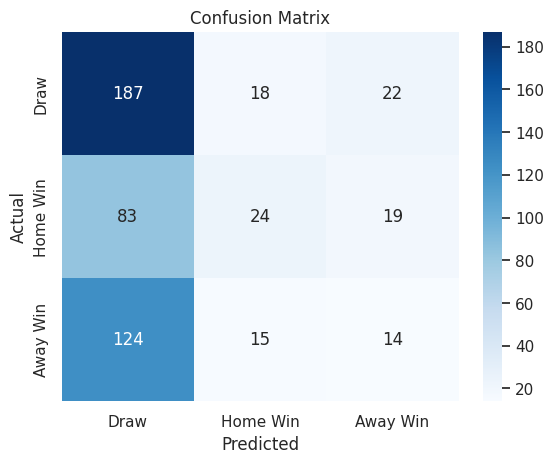

In [100]:
# Predictions and evaluation metrics
y_pred = clf.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Draw', 'Home Win', 'Away Win'], yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [116]:
from sklearn.ensemble import GradientBoostingRegressor

In [117]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)


GradientBoostingRegressor()

In [119]:
# Predictions and evaluation metrics
gbm_y_pred = gbm_model.predict(X_test)
gbm_y_pred = np.round(gbm_y_pred, 0)
gbm_y_pred

# # Accuracy score
# accuracy = accuracy_score(y_test, gbm_y_pred)
# print(f'Accuracy: {accuracy:.2f}')

# # Classification report
# print("Classification Report:\n", classification_report(y_test, gbm_y_pred))

# # Confusion matrix
# conf_matrix = confusion_matrix(y_test, gbm_y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=['Draw', 'Home Win', 'Away Win'], yticklabels=['Draw', 'Home Win', 'Away Win'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


array([1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 1.,
       2., 2., 2., 2., 2.

In [21]:
results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,rank_home,GD_home,rank_away,GD_away,y_real,y_pred,err,%_err
483,14.0,0.0,16.0,-1.0,2,1,1,50.0
187,5.0,9.0,10.0,6.0,2,1,1,50.0
658,13.0,2.0,4.0,9.0,1,0,1,100.0
111,11.0,-1.0,1.0,17.0,1,1,0,0.0
265,12.0,-5.0,20.0,-22.0,1,0,1,100.0
...,...,...,...,...,...,...,...,...
445,4.0,2.0,2.0,8.0,1,0,1,100.0
811,1.0,14.0,9.0,5.0,2,1,1,50.0
541,2.0,8.0,5.0,4.0,0,0,0,NaN
676,17.0,-3.0,8.0,5.0,1,0,1,100.0


In [12]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [13]:
linear_model.coef_, linear_model.intercept_

(array([-2.44053084e-02,  2.49112016e-01, -3.52052927e-03,  5.36763010e-04,
        -2.10038393e-04, -2.82324923e-05]),
 np.float64(0.7738985956567949))

In [14]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred.astype(int)
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,home_score,away_score,weekday,matchday,home_team_num,away_team_num,y_real,y_pred,err,%_err
23629,3.0,1.0,5,10,3,36,1.0,0,1.0,100.0
43458,2.0,1.0,6,13,137,63,1.0,0,1.0,100.0
45365,1.0,1.0,5,19,17,30,0.0,0,0.0,NaN
19839,1.0,0.0,2,11,41,19,1.0,0,1.0,100.0
10859,1.0,3.0,6,6,26,25,2.0,1,1.0,50.0
...,...,...,...,...,...,...,...,...,...,...
27942,3.0,0.0,6,23,67,83,1.0,0,1.0,100.0
39450,1.0,1.0,6,27,94,45,0.0,0,0.0,NaN
35036,2.0,0.0,6,9,26,119,1.0,0,1.0,100.0
42373,4.0,1.0,5,41,16,54,1.0,0,1.0,100.0


In [15]:
# Updated model import
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
# Adjust model setup and training to use Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=1)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=1)

In [17]:
# Predict and evaluate the model
y_pred = clf.predict(X_test)

# Display evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2453
         1.0       1.00      1.00      1.00      5018
         2.0       1.00      1.00      1.00      2129

    accuracy                           1.00      9600
   macro avg       1.00      1.00      1.00      9600
weighted avg       1.00      1.00      1.00      9600

Confusion Matrix:
[[2453    0    0]
 [   0 5018    0]
 [   0    0 2129]]


In [18]:
# Prepare results DataFrame to inspect specific predictions
results_df = X_test.copy()
results_df['y_real'] = y_test
results_df['y_pred'] = y_pred
results_df['correct'] = results_df['y_real'] == results_df['y_pred']
results_df.head(10)  # Display first 10 results

,home_score,away_score,weekday,matchday,home_team_num,away_team_num,y_real,y_pred,correct
23629,3.0,1.0,5,10,3,36,1.0,1.0,True
43458,2.0,1.0,6,13,137,63,1.0,1.0,True
45365,1.0,1.0,5,19,17,30,0.0,0.0,True
19839,1.0,0.0,2,11,41,19,1.0,1.0,True
10859,1.0,3.0,6,6,26,25,2.0,2.0,True
34894,4.0,1.0,6,33,55,108,1.0,1.0,True
22257,0.0,2.0,0,24,18,13,2.0,2.0,True
12665,2.0,1.0,6,37,25,21,1.0,1.0,True
25659,1.0,2.0,5,23,23,31,2.0,2.0,True
43582,5.0,0.0,4,25,61,43,1.0,1.0,True


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

RMSE: 0.0
MAPE: 0.0
R^2: 1.0
